In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import stats
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [55]:
orange_raster_dir = "/home/dat/Workspace/Thesis/orange_predictor/data/rasters_csv/2017-11-17"
csv_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Orange/orange.csv"

In [73]:
df = pd.read_csv(csv_file)
df["raster_path"] = [os.path.join(orange_raster_dir, row["ID"]+".npy") for id, row in df.iterrows()]

In [74]:
EPSILON = 1e-10

def NDVI(R, NIR):
    return (NIR - R) / (NIR + R + EPSILON)

def RedEdge(R, RE):
    return RE / (R + EPSILON)

def EVI(B, R, NIR):
    return 2.5 * (NIR - R) / (NIR + EPSILON) + 6 * R - 7.5 * B + 1 

def MCARI(G, R, RE):
    return (RE - R) - 0.23 * (RE - G) * RE / (R + EPSILON)

def GNDVI(G, NIR):
    return (NIR - G) / (NIR + G + EPSILON)

In [89]:
ndvi, rededge, evi, mcari, gndvi = [], [], [], [], []
for id, row in df.iterrows():
    raster = np.load(row["raster_path"])
    raster = raster[10:-10, 10:-10]
    b, g, r, re, nir = raster[:,:,0], raster[:,:,1], raster[:,:,2], raster[:,:,3], raster[:,:,4]
    ndvi.append(NDVI(r, nir).mean())
    rededge.append(RedEdge(r, re).mean())
    evi.append(EVI(b, r, nir).mean())
    mcari.append(MCARI(g, r, re).mean())
    gndvi.append(GNDVI(g, nir).mean())
    
df["UAV_NDVI"] = ndvi
df["RedEdge"] = rededge
df["EVI"] = evi
df["MCARI"] = mcari
df["GNDVI"] = gndvi

In [90]:
df.head()

,ID,Chlorophyll,NDVI,WP,raster_path,UAV_NDVI,RedEdge,EVI,MCARI,GNDVI
0,14E,45.130,0.790624,-8.498,/home/dat/Workspace/Thesis/orange_predictor/da...,0.346855,2.541812,1.888388,0.178931,0.135388
1,57B,53.224,0.822390,-7.544,/home/dat/Workspace/Thesis/orange_predictor/da...,0.302981,2.643404,1.667225,0.146579,0.136001
2,22E,63.525,0.866294,-8.279,/home/dat/Workspace/Thesis/orange_predictor/da...,0.384220,2.633515,1.872123,0.177297,0.125805
3,51F,61.880,0.871767,-9.449,/home/dat/Workspace/Thesis/orange_predictor/da...,0.348046,3.011177,1.939345,0.120240,0.172623
4,10H,54.390,0.840800,-9.100,/home/dat/Workspace/Thesis/orange_predictor/da...,0.375848,2.756250,2.026001,0.143455,0.188828


In [91]:
print("NDVI & WP:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["WP"])[0])
print("RedEdge & WP:", stats.pearsonr(df.dropna()["RedEdge"], df.dropna()["WP"])[0])
print("EVI & WP:", stats.pearsonr(df.dropna()["EVI"], df.dropna()["WP"])[0])
print("MCARI & WP:", stats.pearsonr(df.dropna()["MCARI"], df.dropna()["WP"])[0])
print("GNDVI & WP:", stats.pearsonr(df.dropna()["GNDVI"], df.dropna()["WP"])[0])

NDVI & WP: 0.430441848807
RedEdge & WP: 0.381747483716
EVI & WP: 0.396546461036
MCARI & WP: 0.383269685187
GNDVI & WP: 0.409452931119


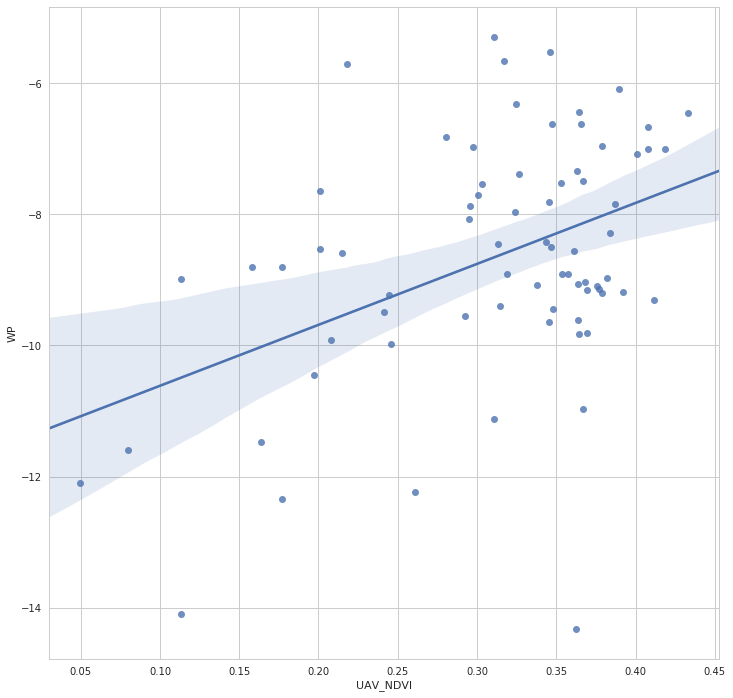

In [93]:
sns.regplot(x=df["UAV_NDVI"], y=df["WP"])

In [92]:
print("NDVI & Chlorophyll:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["Chlorophyll"])[0])
print("RedEdge & Chlorophyll:", stats.pearsonr(df.dropna()["RedEdge"], df.dropna()["Chlorophyll"])[0])
print("EVI & Chlorophyll:", stats.pearsonr(df.dropna()["EVI"], df.dropna()["Chlorophyll"])[0])
print("MCARI & Chlorophyll:", stats.pearsonr(df.dropna()["MCARI"], df.dropna()["Chlorophyll"])[0])
print("GNDVI & Chlorophyll:", stats.pearsonr(df.dropna()["GNDVI"], df.dropna()["Chlorophyll"])[0])

NDVI & Chlorophyll: 0.321558118964
RedEdge & Chlorophyll: 0.419500621615
EVI & Chlorophyll: 0.238750983346
MCARI & Chlorophyll: 0.223664880301
GNDVI & Chlorophyll: 0.213942700956


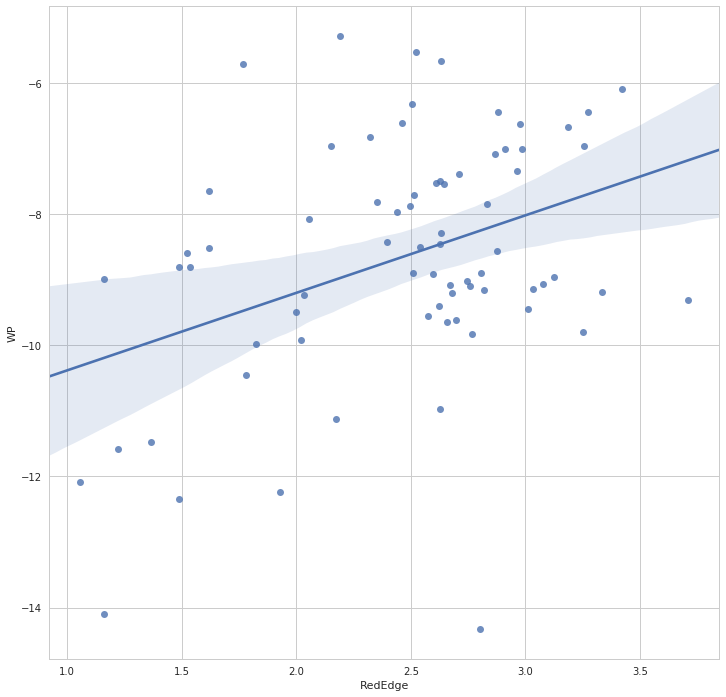

In [94]:
sns.regplot(x=df["RedEdge"], y=df["WP"])

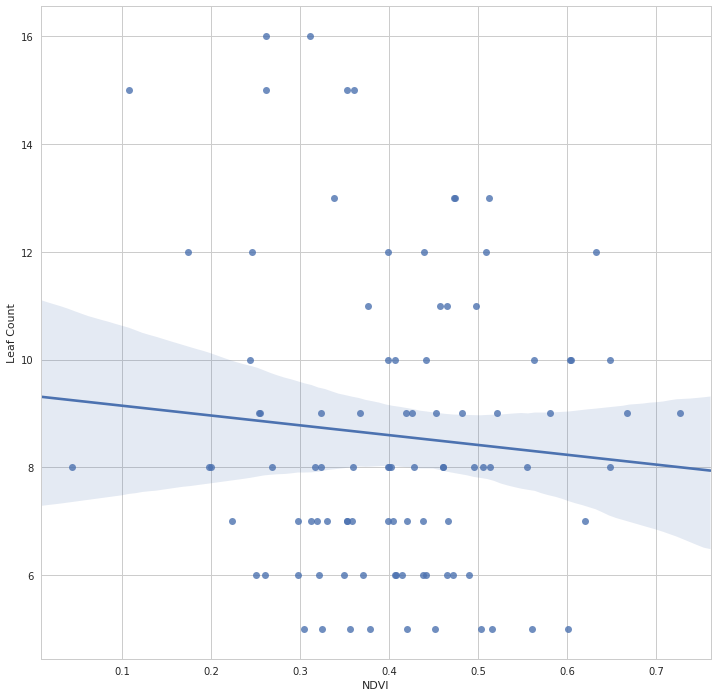

In [33]:
ax = sns.regplot(x=merged_df["uav_ndvi"], y=merged_df["Average Leaf Count"])
ax.set(xlabel="NDVI", ylabel="Leaf Count")

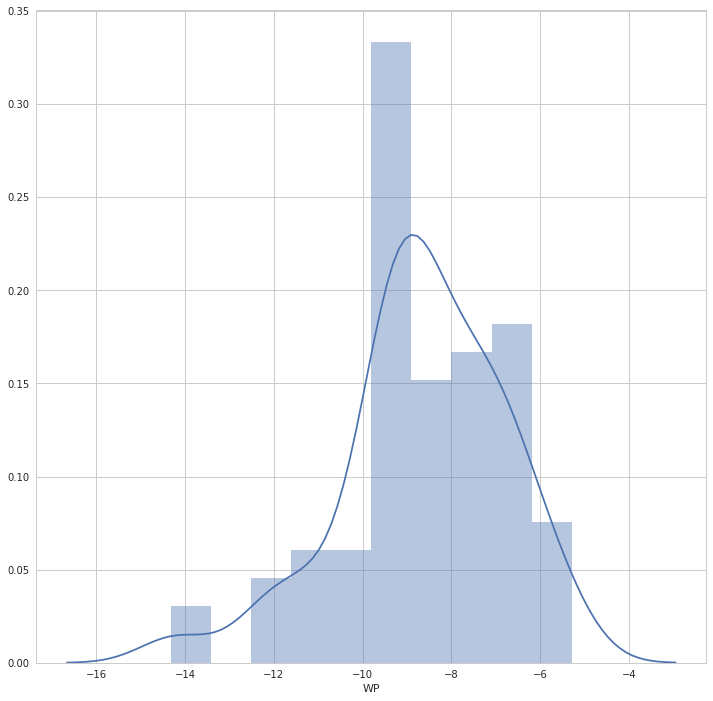

In [7]:
sns.distplot(df["WP"].dropna())

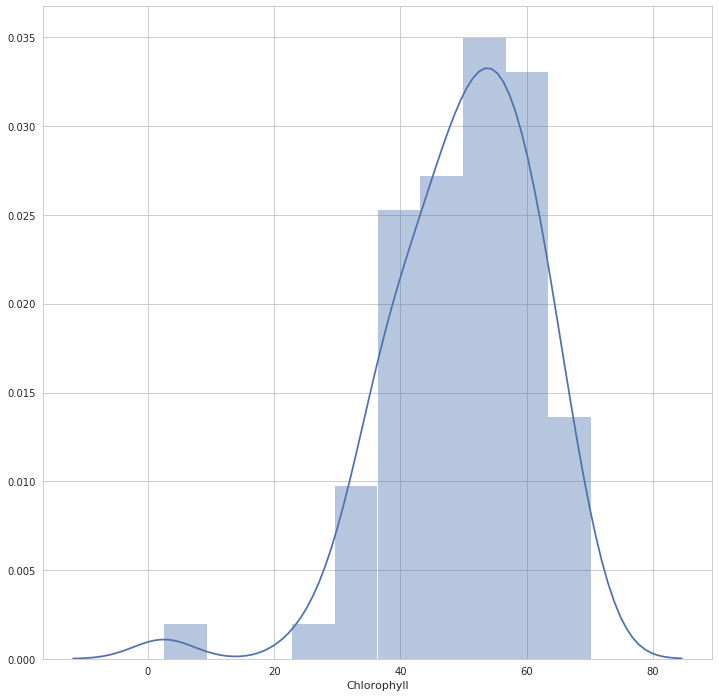

In [8]:
sns.distplot(df["Chlorophyll"].dropna())

Chloropyhll & WP: 0.353851475651


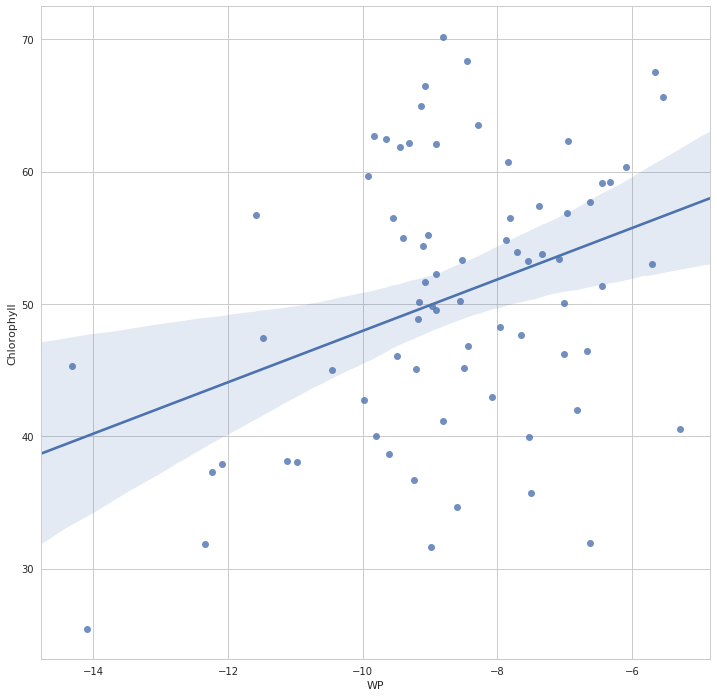

In [11]:
sns.regplot(x=df["WP"], y=df["Chlorophyll"])
print("Chloropyhll & WP:", stats.pearsonr(df.dropna()["Chlorophyll"], df.dropna()["WP"])[0])

### Distribution of NDVI values

In [4]:
lettuce_ndvi = {}
for fname in os.listdir(ndvi_img_dir):
    img = np.asarray(Image.open(os.path.join(ndvi_img_dir, fname)).convert("L")).astype(np.int)
    img = img[1:-1,1:-1]
    ndvi = (np.average(img) - 128) / 128
    lettuce_ndvi[fname.split(".")[0]] = ndvi

In [5]:
ndvi_values = list(lettuce_ndvi.values())

print("Average: %.4f" % np.average(ndvi_values))
print("Std Dev: %.4f" % np.std(ndvi_values))

Average: 0.4078
Std Dev: 0.1289


In [6]:
def RMSE(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.sqrt(np.mean((x1-x2)**2))

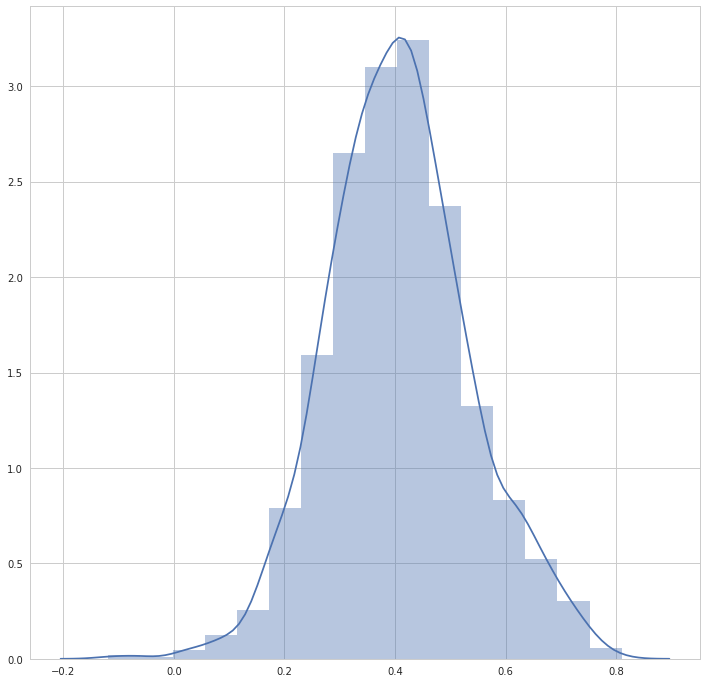

In [7]:
sns.distplot(ndvi_values, bins=16)

### Analyze ground data

In [16]:
print("UAV NDVI & Chlorophyll:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["Chlorophyll"])[0])
print("UAV NDVI & NDVI:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["NDVI"])[0])
print("UAV NDVI & Height:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["Average Height"])[0])
print("UAV NDVI & Leaf Count:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["Average Leaf Count"])[0])
print("UAV NDVI & WP:", stats.pearsonr(merged_df.dropna()["uav_ndvi"], merged_df.dropna()["WP"])[0])

UAV NDVI & Chlorophyll: 0.141602050807
UAV NDVI & NDVI: 0.0953184131443
UAV NDVI & Height: 0.193465430132
UAV NDVI & Leaf Count: -0.0822546741617
UAV NDVI & WP: 0.36813781771


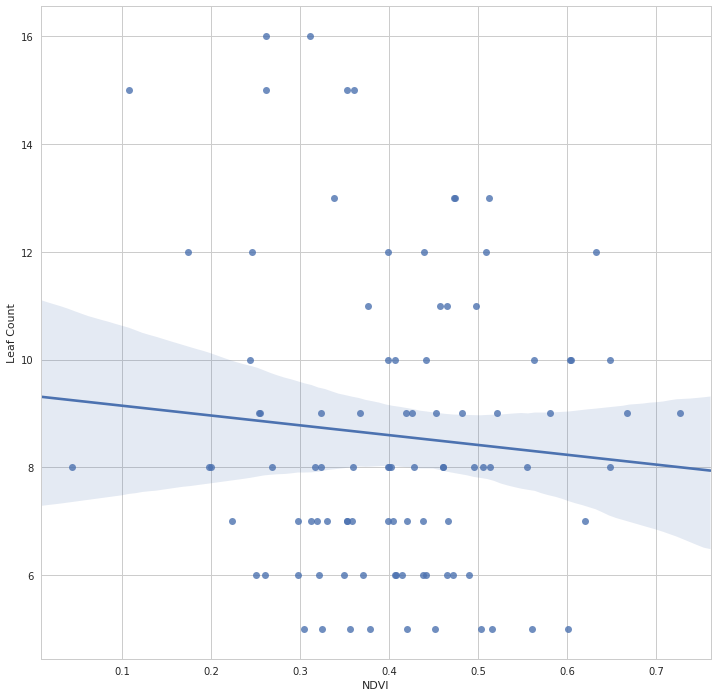

In [33]:
ax = sns.regplot(x=merged_df["uav_ndvi"], y=merged_df["Average Leaf Count"])
ax.set(xlabel="NDVI", ylabel="Leaf Count")